In [3]:
'''
Student Names + (IDs): 

Abdelrahman Mohamed Kamal Abdelaziz (1220255)
Mazen Ahmed Fouad Abdelwahab (1220269)
Mohamed Hesham Ibrahim Hassanain (1220278)
Ahmed Walaa Abdlelkhalek Abdelrahman (1220216)

'''
# Import(s)
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.color import rgb2gray
from skimage.morphology import dilation, erosion
from skimage.measure import find_contours

In [5]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

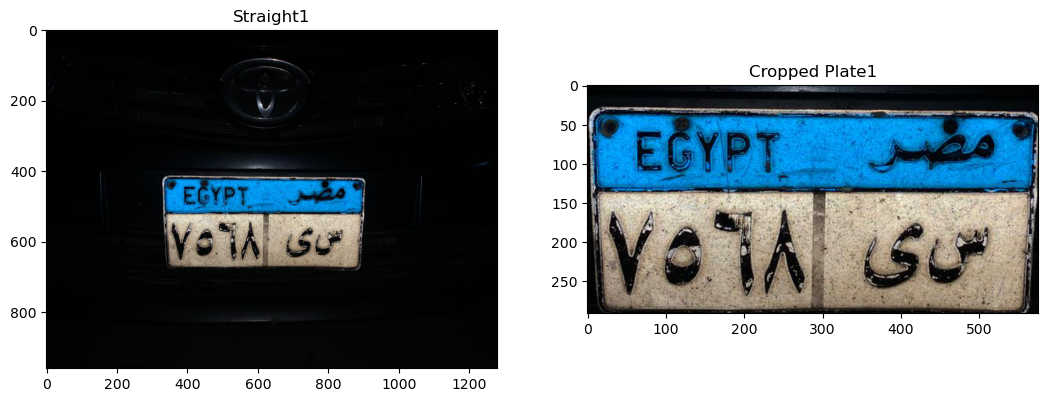

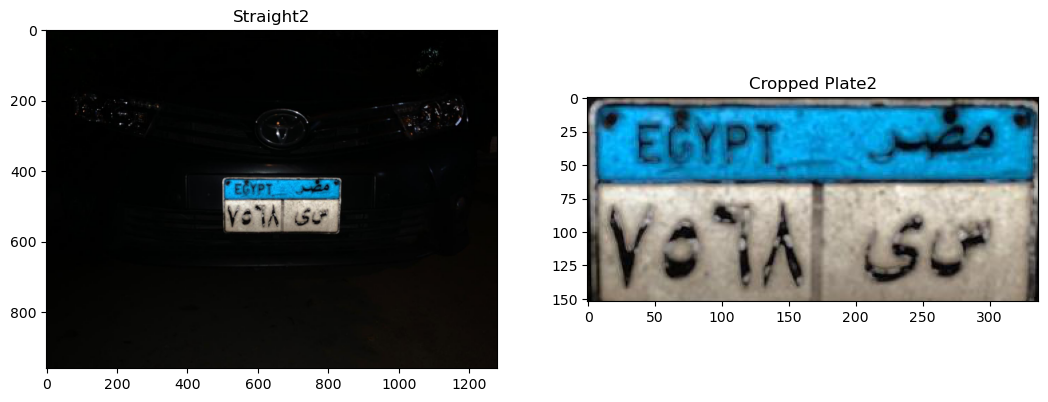

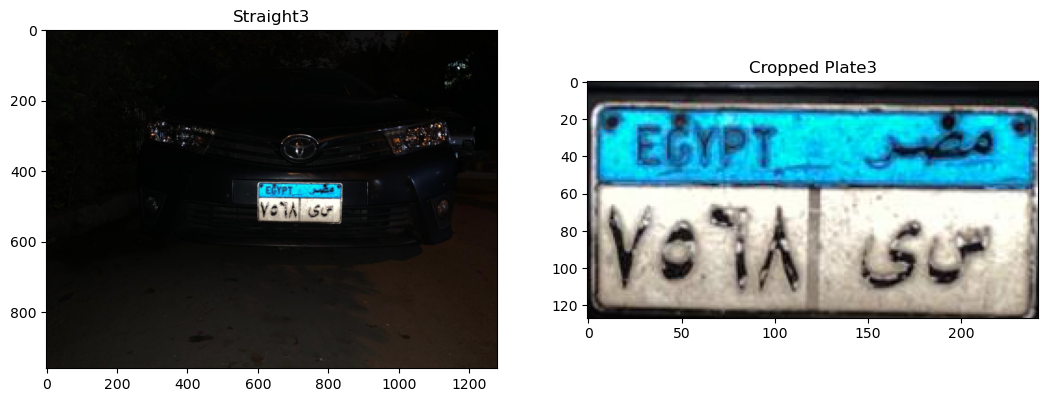

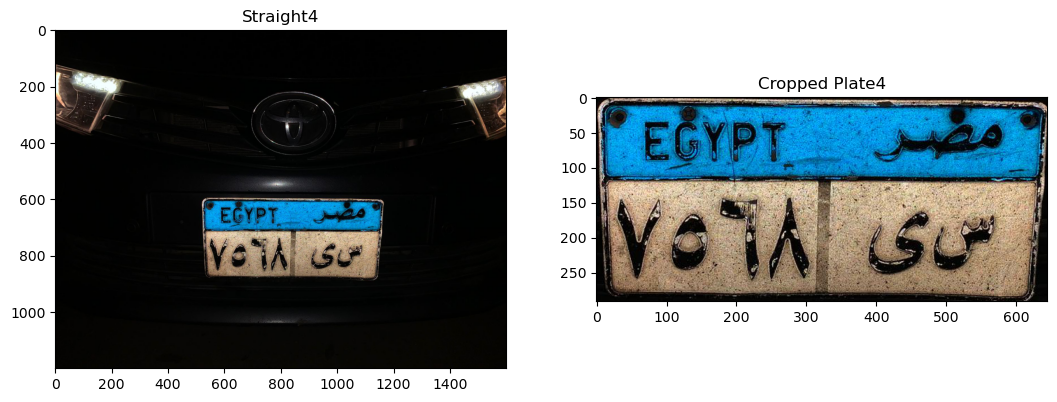

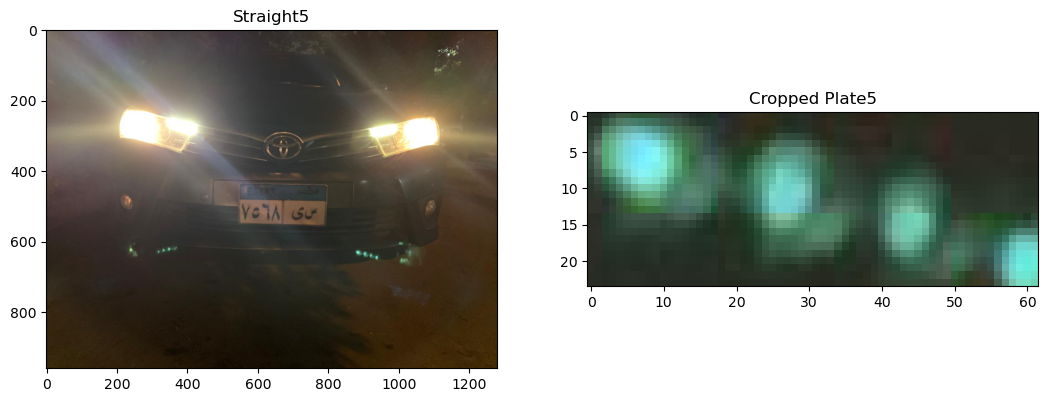

In [6]:
# One Step All Angles No Headlights

Straight1 = io.imread('Localization Test/One Step All Angles No Headlights/Straight.jpeg')
Straight2 = io.imread('Localization Test/Two Step All Angles No Headlights/Straight.jpeg')
Straight3 = io.imread('Localization Test/Three Step All Angles No Headlights/Straight.jpeg')
Straight4 = io.imread('Localization Test/One Step All Angles With Headlights/Straight.jpeg')
Straight5 = io.imread('Localization Test/Two Step All Angles With Headlights/Straight.jpeg')

def preprocess_image(image):
    Gray = rgb2gray(image)
    Binary = Gray > 0.5
    closing = erosion(dilation(Binary,np.ones((30,30))),np.ones((30,30)))
    boxes = find_contours(closing,0.8)
    return boxes

def get_License_Plate(boxes, image):
    for box in boxes:
        y_min, y_max = int(np.min(box[:, 0])), int(np.max(box[:, 0]))
        x_min, x_max = int(np.min(box[:, 1])), int(np.max(box[:, 1]))

        width = x_max - x_min
        height = y_max - y_min

        if height == 0:
            continue

        aspect = width / height
        area = width * height

        if 1.5 < aspect < 2.7 and area > 1000:
            plate = image[y_min:y_max, x_min:x_max]
    
    return plate

boxes1 = preprocess_image(Straight1)
plate_crop1 = get_License_Plate(boxes1, Straight1)

boxes2 = preprocess_image(Straight2)
plate_crop2 = get_License_Plate(boxes2, Straight2)

boxes3 = preprocess_image(Straight3)
plate_crop3 = get_License_Plate(boxes3, Straight3)

boxes4 = preprocess_image(Straight4)
plate_crop4 = get_License_Plate(boxes4, Straight4)

boxes5 = preprocess_image(Straight5)
plate_crop5 = get_License_Plate(boxes5, Straight5)

show_images([Straight1, plate_crop1],['Straight1', 'Cropped Plate1'])
show_images([Straight2, plate_crop2],['Straight2', 'Cropped Plate2'])
show_images([Straight3, plate_crop3],['Straight3', 'Cropped Plate3'])
show_images([Straight4, plate_crop4],['Straight4', 'Cropped Plate4'])
show_images([Straight5, plate_crop5],['Straight5', 'Cropped Plate5'])

Saved clean_digits.png & clean_letters.png
num_labels (including background): 9
label 0: x=0 y=0 w=111 h=41 area=3936
label 1: x=41 y=10 w=13 h=10 area=66
label 2: x=52 y=11 w=1 h=1 area=1
label 3: x=74 y=15 w=15 h=18 area=137
label 4: x=88 y=14 w=3 h=4 area=6
label 5: x=61 y=20 w=2 h=2 area=3
label 6: x=41 y=23 w=1 h=1 area=1
label 7: x=22 y=24 w=30 h=17 area=268
label 8: x=57 y=24 w=20 h=17 area=133
plate_area=30734, min_area=153.67000000000002, max_area=7683.5
min_height_px=19.05, max_height_px=50.800000000000004
Found candidate boxes: 2


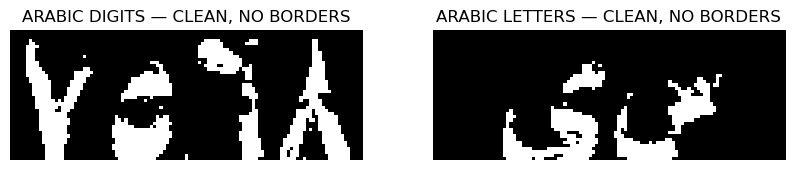

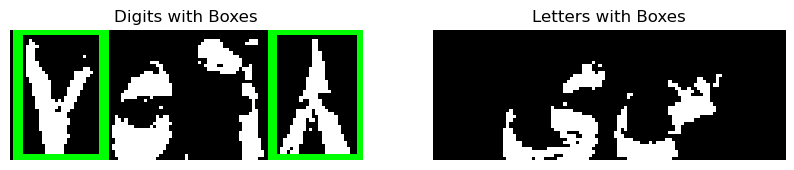

In [180]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology
import numpy as np
from skimage import img_as_ubyte


def preprocess_plate_with_smoothing(img, debug=True):
    """
    Preprocess the localized license plate image with:
    - Pre-threshold smoothing (median blur)
    - CLAHE
    - Adaptive thresholding
    - Post-threshold noise removal (morphological opening)
    Returns the final cleaned binary image.
    """
    # ---------------- 1. Convert to grayscale ----------------
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---------------- 2. Optional pre-threshold smoothing ----------------
    # Reduce scattered grayscale noise before thresholding
    gray_smooth = cv2.medianBlur(gray, ksize=3)  # small kernel

    # ---------------- 3. CLAHE ----------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray_smooth)

    # ---------------- 4. Adaptive Threshold ----------------
    H, W = enhanced.shape
    block_size = int(max(15, (H // 7) | 1))  # odd
    C = 8
    binary = cv2.adaptiveThreshold(
        enhanced,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=block_size,
        C=C
    )

    # ---------------- 5. Invert if needed ----------------------------------
    white_ratio = np.mean(binary == 255)
    if white_ratio > 0.55:
        binary = cv2.bitwise_not(binary)

    # ---------------- 6. Post-threshold noise removal ----------------
    # Remove tiny white speckles
    h, w = binary.shape
    k_open = max(1, round(h * 0.015))  # kernel proportional to plate height
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_open, k_open))
    cleaned_binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # ---------------- 7. Debug visualization ----------------
    if debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1,4,1)
        plt.imshow(gray, cmap='gray'); plt.title("Grayscale"); plt.axis("off")
        plt.subplot(1,4,2)
        plt.imshow(gray_smooth, cmap='gray'); plt.title("Median Smoothed"); plt.axis("off")
        plt.subplot(1,4,3)
        plt.imshow(binary, cmap='gray'); plt.title("Adaptive Threshold"); plt.axis("off")
        plt.subplot(1,4,4)
        plt.imshow(cleaned_binary, cmap='gray'); plt.title("After Morph Open"); plt.axis("off")
        plt.show()

    return cleaned_binary


def crop_one_side(img, mask, side, threshold=0.02, max_px=21):
    """
    Crops ONE SIDE ONLY (top, bottom, left, right) by 1px repeatedly.
    Stops when that side becomes clean OR when image would become too small.
    """
    for _ in range(max_px):

        # HARD SAFETY — never allow cropping if too small
        if img.shape[0] < 10 or img.shape[1] < 10:
            break

        if side == "top":
            border_val = mask[0, :].mean()
            if border_val > threshold:
                img  = img[1:, :]
                mask = mask[1:, :]
            else:
                break

        elif side == "bottom":
            border_val = mask[-1, :].mean()
            if border_val > threshold:
                img  = img[:-1, :]
                mask = mask[:-1, :]
            else:
                break

        elif side == "left":
            border_val = mask[:, 0].mean()
            if border_val > threshold:
                img  = img[:, 1:]
                mask = mask[:, 1:]
            else:
                break

        elif side == "right":
            border_val = mask[:, -1].mean()
            if border_val > threshold:
                img  = img[:, :-1]
                mask = mask[:, :-1]
            else:
                break

    return img, mask


def clean_crop(img, mask):
    img, mask = crop_one_side(img, mask, "top")
    img, mask = crop_one_side(img, mask, "bottom")
    img, mask = crop_one_side(img, mask, "left")
    img, mask = crop_one_side(img, mask, "right")
    return img, mask


# ======================================================================
# WHITE BACKGROUND RENDERING
# ======================================================================
def make_clean(region_img, region_mask):
    clean = np.ones_like(region_img)
    clean[region_mask] = region_img[region_mask]
    return clean




def remove_plate_header(plate_img, header_ratio=0.2):

    """
    Crops out the top header rectangle (Egypt / مصر) from a license plate.
    
    Parameters:
        plate_img: binary or grayscale plate image
        header_ratio: proportion of height to remove from top (0.0–1.0)
    
    Returns:
        cropped_img: the plate without the top header
    """
    h, w = plate_img.shape[:2]
    header_height = int(h * header_ratio)
    
    # Keep only the bottom part
    cropped_img = plate_img[header_height:, :]
    
    return cropped_img



def morphological_and_CCL(binary_img,left,right,debug=True):
    """
    Takes the binarized plate image (white foreground, black background)
    and performs:
      - Small opening
      - Small closing
      - Connected Components (8-connectivity)
      - Character plausibility filtering (relative thresholds)
    Returns:
      cleaned_binary, boxes, stats_all, labels, num_labels
    """

    # ---------- STEP 2: Morphological Cleaning ----------
    h, w = binary_img.shape[:2]

    # Kernel sizes scaled to image height
    # k1 = max(1, round(h * 0.01))  # opening kernel
    # k2 = max(1, round(h * 0.025))   # closing kernel

    # kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (k1, k1))
    # kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (k2, k2))

    # # Small opening to remove tiny speckles
    # opened = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel1,iterations=1)

    # # Small closing to fill small holes in characters
    # closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel2,iterations=1)

    # cleaned_binary = closed.copy()

    # # Force binary exact values (0,255) and uint8
    # cleaned_binary = np.where(cleaned_binary > 0, 255, 0).astype(np.uint8)

    # if debug:
    #     print("After morphology: dtype:", cleaned_binary.dtype, "unique:", np.unique(cleaned_binary))
    #     print("White pixel count:", int(np.sum(cleaned_binary == 255)))


    # cropped_plate = remove_plate_header(cleaned_binary, header_ratio=0.45)
    # noborders= remove_white_borders(cleaned_binary)

    
    
    # ---------- STEP 3: Connected Components (8-connectivity) ----------

    left = (left > 0).astype("uint8") * 255
    right = (right > 0).astype("uint8") * 255

    num_labels1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(
        left,
        connectivity=8,
        ltype=cv2.CV_32S
    )
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        right,
        connectivity=8,
        ltype=cv2.CV_32S
    )

    

    if debug:
        print("num_labels (including background):", num_labels)
        # optionally print first few stats
        for i in range(min(num_labels, 12)):
            x,y,wb,hb,area = stats[i]
            print(f"label {i}: x={x} y={y} w={wb} h={hb} area={area}")

    # ---------- STEP 5: Bounding-Box Filtering (RELATIVE thresholds) ----------
    boxesleft = []
    stats_allleft = []
    boxesright = []
    stats_allright = []

    plate_area = h * w

    # Reasonable starting thresholds (relative)
    min_area = plate_area * 0.005   # 0.5% of plate area
    max_area = plate_area * 0.25    # 25% of plate area (likely merged)
    min_aspect = 0.08               # w/h (allow narrow digits)   0.08 
    max_aspect = 1.4                # some letters might be wider than digits

    min_height = h * 0.15           # allow small characters (15% of plate height)
    max_height = h * 0.4

    if debug:
        print(f"plate_area={plate_area}, min_area={min_area}, max_area={max_area}")
        print(f"min_height_px={min_height}, max_height_px={max_height}")

    for label in range(1, num_labels1):  # skip background label 0
        x, y, w_b, h_b, area = stats1[label]
        stats_allleft.append((label, x, y, w_b, h_b, area))

        # area filtering
        if area < min_area:
            continue
        if area > max_area:
            continue  # merged objects (we're skipping splitting per your instruction)

        aspect = w_b / float(max(1, h_b))

        # aspect ratio filtering
        if aspect < min_aspect or aspect > max_aspect:
            continue

        # height filtering
        if h_b < min_height or h_b > max_height:
            continue

        boxesleft.append((x, y, w_b, h_b))
        
    for label in range(1, num_labels):  # skip background label 0
        x, y, w_b, h_b, area = stats[label]
        stats_allright.append((label, x, y, w_b, h_b, area))

        # area filtering
        if area < min_area:
            continue
        if area > max_area:
            continue  # merged objects (we're skipping splitting per your instruction)

        aspect = w_b / float(max(1, h_b))

        # aspect ratio filtering
        if aspect < min_aspect or aspect > max_aspect:
            continue

        # height filtering
        if h_b < min_height or h_b > max_height:
            continue

        boxesright.append((x, y, w_b, h_b))

    if debug:
        print("Found candidate boxes:", len(boxesleft)+len(boxesright))
        # show bounding boxes overlay for quick visual check (returns BGR image)
        dbg = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
        for (x, y, wb, hb) in boxesleft:
            cv2.rectangle(dbg, (x, y), (x+wb, y+hb), (0,255,0), 2)
        dbg2 = cv2.cvtColor(right, cv2.COLOR_GRAY2BGR)
        for (x, y, wb, hb) in boxesright:
            cv2.rectangle(dbg, (x, y), (x+wb, y+hb), (0,255,0), 2)
        # Display inline if desired (plt or cv2.imshow)
        # cv2.imshow("ccl_debug", dbg); cv2.waitKey(0)
        # For notebooks, convert and display with matplotlib:
        try:
            from matplotlib import pyplot as plt
            # plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
            # plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(dbg2, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
        except Exception:
            pass

    # ensure expected number (2–7 components)
    if len(boxesleft)+len(boxesright) < 2 or len(boxesleft)+len(boxesright) > 7:
        print("⚠ Warning: suspicious number of character candidates =", len(boxesleft)+len(boxesright))

    return boxesleft,boxesright,left,right


def draw_components(imgL,imgR, boxesL,boxesR, pad=3):
    """Draws padded bounding boxes on the image for visualization."""
    out = cv2.cvtColor(imgL.copy(), cv2.COLOR_GRAY2BGR)
    H, W = imgL.shape[:2]

    for (x, y, w, h) in boxesL:
        # Expand bounding box
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W - 1, x + w + pad)
        y2 = min(H - 1, y + h + pad)

        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 255, 0), 2)
    out2 = cv2.cvtColor(imgR.copy(), cv2.COLOR_GRAY2BGR)
    H, W = imgR.shape[:2]

    for (x, y, w, h) in boxesR:
        # Expand bounding box
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W - 1, x + w + pad)
        y2 = min(H - 1, y + h + pad)

        cv2.rectangle(out2, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return out,out2

import cv2
import numpy as np
from matplotlib import pyplot as plt

def _ensure_binary_uint8(img):
    img = np.asarray(img)
    if img.dtype != np.uint8:
        img = (img > 0).astype(np.uint8) * 255
    else:
        # ensure exact 0/255
        img = np.where(img > 0, 255, 0).astype(np.uint8)
    return img




def manual_sort_boxes(boxes):
    """
    Sort boxes by x-coordinate (left-to-right) manually.
    boxes: list of (x, y, w, h)
    returns: sorted list
    """
    sorted_boxes = []

    for box in boxes:
        x = box[0]
        inserted = False
        for i, b in enumerate(sorted_boxes):
            if x < b[0]:
                sorted_boxes.insert(i, box)
                inserted = True
                break
        if not inserted:
            sorted_boxes.append(box)

    return sorted_boxes


def save_characters(characters_sortedL, characters_sortedR):
    """
    Saves sorted character images from digits (left) and letters (right).
    
    Parameters:
        characters_sortedL: list of (x, y, w, h, img) for digits
        characters_sortedR: list of (x, y, w, h, img) for letters
    """
    # Save digits
    for i, (_, _, _, _, img) in enumerate(characters_sortedL):
        cv2.imwrite(f"digit_{i}.png", img)

    # Save letters
    for i, (_, _, _, _, img) in enumerate(characters_sortedR):
        cv2.imwrite(f"letter_{i}.png", img)


def crop_characters(binary_img, boxes, resize_to=(64, 64), pad_ratio=0.09):
    """
    Returns list of tuples: (x, y, w, h, char_img) with padded cropping.
    """
    H, W = binary_img.shape[:2]
    characters = []

    for (x, y, w_b, h_b) in boxes:

        # Compute proportional padding from box size
        pad_x = int(w_b * pad_ratio)
        pad_y = int(h_b * pad_ratio)

        # Apply padded crop
        x1 = max(0, x - pad_x)
        y1 = max(0, y - pad_y)
        x2 = min(W, x + w_b + pad_x)
        y2 = min(H, y + h_b + pad_y)

        char_img = binary_img[y1:y2, x1:x2]

        # Resize if needed
        if resize_to is not None:
            char_img = cv2.resize(char_img, resize_to, interpolation=cv2.INTER_NEAREST)

        characters.append((x, y, w_b, h_b, char_img))

    return characters




# img = io.imread("Dataset/Vehicles with unpaid customs.png")[:,:,:3]
img=plate_crop3
gray = color.rgb2gray(img)

# 1) Crop bottom part (Arabic region)
h = gray.shape[0]
plate = gray[int(h * 0.35):, :]


# 2) Threshold + clean
th = filters.threshold_otsu(plate)
mask = plate < th

mask = morphology.remove_small_objects(mask, 0.1)
mask = morphology.remove_small_holes(mask, 0.1)

# 3) Split halves
H, W = mask.shape
digits_img  = plate[:, :W // 2]
letters_img = plate[:, W // 2:]

digits_mask  = mask[:, :W // 2]
letters_mask = mask[:, W // 2:]


# 4) SAFE crop each half independently
digits_img_c,  digits_mask_c  = clean_crop(digits_img, digits_mask)
letters_img_c, letters_mask_c = clean_crop(letters_img, letters_mask)

# 5) Build final clean images
clean_digits  = make_clean(digits_img_c, digits_mask_c)
clean_letters = make_clean(letters_img_c, letters_mask_c)

# 6) Show results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(digits_mask_c, cmap="gray")
plt.title("ARABIC DIGITS — CLEAN, NO BORDERS")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(letters_mask_c, cmap="gray")
plt.title("ARABIC LETTERS — CLEAN, NO BORDERS")
plt.axis("off")

# 7) Save
io.imsave("clean_digits.png", img_as_ubyte(clean_digits))
io.imsave("clean_letters.png", img_as_ubyte(clean_letters))
print("Saved clean_digits.png & clean_letters.png")

# Straight1 = io.imread('Dataset/image.png')
# image=plate_crop1
# image=Straight1
# proccesded=preprocess_plate_with_smoothing(image)
boxesL, boxesR,leftT,rightT= morphological_and_CCL(img,digits_mask_c,letters_mask_c,debug=True)
# draw_components(leftT,rightT,boxesL,boxesR)

out_digits, out_letters = draw_components(leftT, rightT, boxesL, boxesR)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(out_digits)
plt.title("Digits with Boxes")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(out_letters)
plt.title("Letters with Boxes")
plt.axis("off")
plt.show()

# Sort boxes by x-coordinate
boxes_sortedL = manual_sort_boxes(boxesL)
boxes_sortedR = manual_sort_boxes(boxesR)

# Crop in that order
charimages_sortedL = crop_characters(leftT, boxes_sortedL)
charimages_sortedR = crop_characters(rightT, boxes_sortedR)
save_characters(charimages_sortedL,charimages_sortedR)